In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_SE.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - Consumo de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego
0,2003-1,0.669217,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.339447,152.791400,23.616,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943
1,2003-2,0.669542,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.341257,151.964054,21.357,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067
2,2003-3,0.669868,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.343016,154.467758,20.059,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190
3,2003-4,0.670193,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.344722,155.913400,19.920,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313
4,2003-5,0.670519,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.346174,157.467159,19.962,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.557749,169.752591,34.037,NaN,NaN,NaN,NaN,NaN
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.556659,169.621865,32.537,NaN,NaN,NaN,NaN,NaN
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555237,169.855545,35.215,NaN,NaN,NaN,NaN,NaN
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553445,170.188727,34.707,NaN,NaN,NaN,NaN,NaN


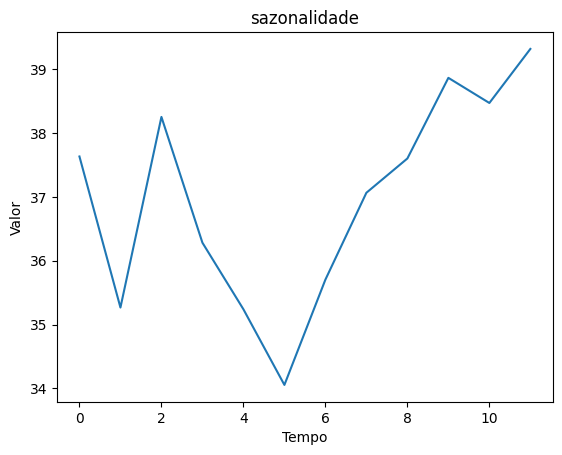

,sazonalidade
sazonalidade,
0,37.634714
1,35.266071
2,38.255214
3,36.282786
4,35.238857
5,34.052571
6,35.703714
7,37.066000
8,37.603429


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade,Sergipe - Consumo de Cimento (t)
0,2003-1,0.669217,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943,37.634714,23.616
1,2003-2,0.669542,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067,35.266071,21.357
2,2003-3,0.669868,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190,38.255214,20.059
3,2003-4,0.670193,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313,36.282786,19.920
4,2003-5,0.670519,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437,35.238857,19.962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.557749,169.752591,NaN,NaN,NaN,NaN,NaN,37.066000,34.037
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.556659,169.621865,NaN,NaN,NaN,NaN,NaN,37.603429,32.537
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555237,169.855545,NaN,NaN,NaN,NaN,NaN,38.867929,35.215
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.553445,170.188727,NaN,NaN,NaN,NaN,NaN,38.473857,34.707


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
235       NaN
236       NaN
237       NaN
238       NaN
239       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 240, dtype: float64

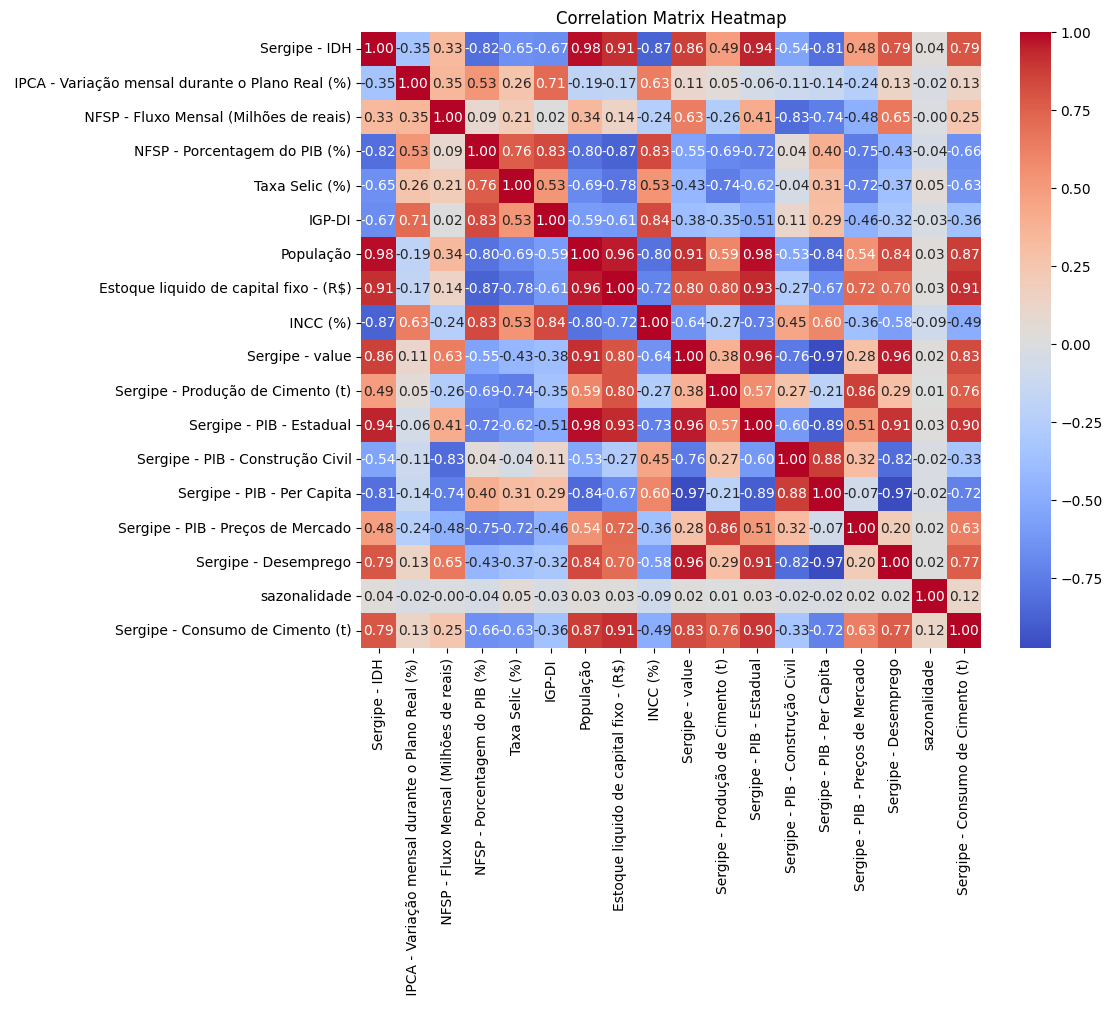

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Sergipe - IDH,1.551889e+06
1,IPCA - Variação mensal durante o Plano Real (%),2.356468e+03
2,NFSP - Fluxo Mensal (Milhões de reais),2.428206e+02
3,NFSP - Porcentagem do PIB (%),1.963684e+02
4,Taxa Selic (%),5.719439e+01
5,IGP-DI,3.813639e+02
6,População,3.675362e+06
7,Estoque liquido de capital fixo - (R$),1.346837e+07
8,INCC (%),1.221672e+03
9,Sergipe - value,5.806999e+04


In [40]:
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 0


,Sergipe - IDH,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego,sazonalidade
0,0.669217,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,0.339447,152.791400,2.159732e+07,1.260978e+06,9.960678,2.029642e+07,8.389943,37.634714
1,0.669542,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,0.341257,151.964054,2.162153e+07,1.262134e+06,9.961956,2.030238e+07,8.384067,35.266071
2,0.669868,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,0.343016,154.467758,2.164574e+07,1.263289e+06,9.963234,2.030833e+07,8.378190,38.255214
3,0.670193,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,0.344722,155.913400,2.166995e+07,1.264444e+06,9.964512,2.031429e+07,8.372313,36.282786
4,0.670519,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,0.346174,157.467159,2.169416e+07,1.265599e+06,9.965790,2.032025e+07,8.366437,35.238857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.700526,0.366904,-5783.316460,2.206994,0.545067,0.471521,1.987710e+08,7.783063e+06,0.378150,0.465001,176.557134,2.495171e+07,1.201196e+06,9.826200,2.044311e+07,13.674967,37.066000
176,0.700537,0.358935,-6001.730740,2.215328,0.782910,0.476827,1.988450e+08,7.780841e+06,0.377666,0.463900,176.140993,2.494830e+07,1.200540e+06,9.826782,2.044282e+07,13.667766,37.603429
177,0.700548,0.354313,-6454.887704,2.232466,0.909682,0.475427,1.989190e+08,7.778619e+06,0.377838,0.462770,175.707193,2.494490e+07,1.199884e+06,9.827364,2.044253e+07,13.660565,38.867929
178,0.700559,0.352728,-6243.191421,2.263185,1.050614,0.491301,1.989930e+08,7.776397e+06,0.370057,0.461552,174.879535,2.494149e+07,1.199229e+06,9.827946,2.044225e+07,13.653364,38.473857


In [41]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.264661,-1.735466,-1.713206,-0.378558,0.493840,-2.673072,-0.793096
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.229611,-1.757716,-1.691835,-0.345145,0.512856,-2.580668,-0.795484
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.195546,-1.690385,-1.670465,-0.311731,0.531873,-2.488265,-0.797872
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.162500,-1.651508,-1.649094,-0.278318,0.550890,-2.395862,-0.800260
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.134378,-1.609723,-1.627724,-0.244904,0.569907,-2.303458,-0.802647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.429358,0.425789,-0.584804,-1.503380,-0.514871,1.368581,0.605679,-1.872446,1.166644,-1.096345,1.247832,-2.107812,-1.507441,-0.397627,1.354253
176,-1.523783,0.339575,-0.580461,-0.733634,-0.473208,1.380202,0.591420,-1.876611,1.145333,-1.107536,1.244826,-2.126777,-1.498780,-0.402099,1.351327
177,-1.578548,0.160702,-0.571531,-0.323353,-0.484199,1.391823,0.577161,-1.875135,1.123449,-1.119202,1.241820,-2.145741,-1.490118,-0.406572,1.348402
178,-1.597335,0.244264,-0.555524,0.132757,-0.359568,1.403443,0.562902,-1.942040,1.099866,-1.141460,1.238814,-2.164706,-1.481457,-0.411044,1.345476


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego
0,2.802383,0.604311,4.268118,2.039314,3.921218,-2.016914,-2.299937,3.214079,-1.264661,-1.735466,-1.713206,-0.378558,0.493840,-2.673072,-0.793096
1,2.402642,0.609431,4.096014,1.195209,3.582946,-1.988421,-2.263992,3.051841,-1.229611,-1.757716,-1.691835,-0.345145,0.512856,-2.580668,-0.795484
2,2.158351,0.562720,3.903698,2.960381,3.422548,-1.959928,-2.228047,2.944772,-1.195546,-1.690385,-1.670465,-0.311731,0.531873,-2.488265,-0.797872
3,2.049492,0.455907,3.693727,1.040752,3.167136,-1.931435,-2.192102,2.842174,-1.162500,-1.651508,-1.649094,-0.278318,0.550890,-2.395862,-0.800260
4,1.905441,0.498418,3.454992,2.351150,2.986591,-1.902941,-2.156157,3.059587,-1.134378,-1.609723,-1.627724,-0.244904,0.569907,-2.303458,-0.802647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.960452,1.465326,-0.676734,0.472779,-1.087000,1.228701,0.759879,-1.491033,1.456089,-0.586003,1.250730,-1.774120,-1.618367,-0.451394,1.409300
164,-1.007966,1.351131,-0.668750,0.302784,-0.904679,1.240408,0.749001,-1.525186,1.429345,-0.645960,1.254359,-1.814307,-1.608308,-0.434380,1.402387
165,-0.976556,1.143146,-0.657609,0.339539,-0.900134,1.252114,0.738124,-1.546744,1.401562,-0.701322,1.257987,-1.854495,-1.598249,-0.417365,1.395474
166,-1.146834,1.542609,-0.647588,0.472795,-1.136836,1.263821,0.727246,-1.586381,1.375470,-0.765685,1.261616,-1.894683,-1.588190,-0.400350,1.388560


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
163    31.132
164    30.195
165    31.537
166    30.748
167    30.734
Name: Sergipe - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 15)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Sergipe - value,Sergipe - Produção de Cimento (t),Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - Desemprego
132,1.530065,0.817451,-0.366715,-0.530011,0.174628,0.848407,0.965586,-0.066954,1.054235,1.250661,1.030863,-0.560119,-0.975343,0.646410,1.120571
133,1.649361,1.130195,-0.350285,-0.532694,0.240832,0.861179,0.962419,-0.130652,1.102829,1.215762,1.040806,-0.598652,-1.014591,0.581816,1.137696
134,1.622916,1.160498,-0.335122,-0.186421,0.176857,0.873950,0.959252,-0.079602,1.152381,1.174596,1.050750,-0.637186,-1.053838,0.517221,1.154821
135,1.581460,1.131990,-0.321950,-0.719664,-0.005233,0.886722,0.956085,-0.034473,1.200862,1.131777,1.060693,-0.675719,-1.093086,0.452627,1.171946
136,1.638292,1.384387,-0.302995,-0.798520,0.097576,0.899493,0.952918,-0.177535,1.239242,1.087815,1.070637,-0.714253,-1.132334,0.388033,1.189071
137,1.643773,1.375487,-0.290554,-0.612129,0.431487,0.912265,0.949751,-0.208868,1.277913,1.042472,1.080580,-0.752787,-1.171582,0.323439,1.206196
138,1.704584,1.438928,-0.281926,-0.476740,0.482414,0.925036,0.946584,-0.245300,1.312457,0.995875,1.090524,-0.791320,-1.210829,0.258845,1.223321
139,1.841703,1.569590,-0.275931,-0.211736,0.657043,0.937808,0.943417,-0.333490,1.352907,0.947932,1.100467,-0.829854,-1.250077,0.194251,1.240446
140,1.837218,1.584058,-0.271466,-0.484608,0.678386,0.950580,0.940250,-0.296846,1.392590,0.898311,1.110411,-0.868387,-1.289325,0.129656,1.257571
141,1.797860,1.166380,-0.273241,-0.183907,0.727143,0.963351,0.937082,-0.292462,1.429120,0.846838,1.120354,-0.906921,-1.328573,0.065062,1.274696


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 15)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2802691578, 2400552899, 1800381824, 3791188583, 3617197356, 2014194563, 3002512114, 1822019043, 4246036138, 3953724128]


Step: 0 ___________________________________________
val_loss: 49.866580963134766
winner_seed: 2802691578


Step: 1 ___________________________________________
val_loss: 8.778278350830078
winner_seed: 2400552899


Step: 2 ___________________________________________
val_loss: 53.32257843017578


Step: 3 ___________________________________________
val_loss: 4.21476411819458
winner_seed: 3791188583


Step: 4 ___________________________________________
val_loss: 12.613639831542969


Step: 5 ___________________________________________
val_loss: 48.314453125


Step: 6 ___________________________________________
val_loss: 18.882020950317383


Step: 7 ___________________________________________
val_loss: 56.391265869140625


Step: 8 ___________________________________________
val_loss: 60.71483612060547


Step: 9 ___________________________________________
val_loss: 51.2488

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.550833,29.653967,29.712711,29.714365,29.748631,29.979147,29.611376,29.870003,30.333261,30.115877,29.800375,29.503166
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,7.016169,1.195034,1.308289,1.722635,1.78437,3.548147,3.633375,0.010002,8.711737,15.097124,12.436625,10.228832


0.16270273441151065

[2278820521, 614917590, 988587647, 2315758169, 2222634641, 47696853, 2744989383, 2420057556, 3794914518, 3123875436]


Step: 0 ___________________________________________
val_loss: 7.6382246017456055
winner_seed: 2278820521


Step: 1 ___________________________________________
val_loss: 14.86730670928955


Step: 2 ___________________________________________
val_loss: 6.481932640075684
winner_seed: 988587647


Step: 3 ___________________________________________
val_loss: 22.398639678955078


Step: 4 ___________________________________________
val_loss: 11.42141342163086


Step: 5 ___________________________________________
val_loss: 54.63319778442383


Step: 6 ___________________________________________
val_loss: 41.64347839355469


Step: 7 ___________________________________________
val_loss: 51.10817337036133


Step: 8 ___________________________________________
val_loss: 61.087974548339844


Step: 9 ___________________________________________
val_loss: 577.217529296875
1/1 [=========

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.867981,33.287735,34.04937,34.250061,34.403934,35.737217,33.870926,34.465321,35.15617,34.118614,32.822292,31.557846
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.69902,2.438734,3.02837,2.813061,2.870934,9.306217,7.892925,4.60532,3.888828,11.094387,9.414707,8.174152


0.1713250504275054

[2796108260, 1669081071, 1342298232, 4051664225, 1423540860, 2676734998, 1247626672, 2743232247, 1689069828, 1884744020]


Step: 0 ___________________________________________
val_loss: 7.856017112731934
winner_seed: 2796108260


Step: 1 ___________________________________________
val_loss: 10.313745498657227


Step: 2 ___________________________________________
val_loss: 53.6656379699707


Step: 3 ___________________________________________
val_loss: 14.002180099487305


Step: 4 ___________________________________________
val_loss: 5.427351474761963
winner_seed: 1423540860


Step: 5 ___________________________________________
val_loss: 3.4837989807128906
winner_seed: 2676734998


Step: 6 ___________________________________________
val_loss: 7.708347320556641


Step: 7 ___________________________________________
val_loss: 10.922102928161621


Step: 8 ___________________________________________
val_loss: 49.11855697631836


Step: 9 ___________________________________________
val_loss: 54

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.697554,32.419395,33.151775,31.871035,31.619669,33.432953,30.340548,32.585842,34.280228,31.749655,30.288523,29.633673
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.869448,1.570395,2.130775,0.434034,0.086668,7.001953,4.362547,2.725842,4.764771,13.463346,11.948477,10.098326


0.15724837611757575

[2517362628, 2718324818, 3257032232, 2624528136, 994283855, 915096679, 570359884, 1545227287, 3970319434, 3256172690]


Step: 0 ___________________________________________
val_loss: 51.785430908203125
winner_seed: 2517362628


Step: 1 ___________________________________________
val_loss: 39.024497985839844
winner_seed: 2718324818


Step: 2 ___________________________________________
val_loss: 53.0311393737793


Step: 3 ___________________________________________
val_loss: 7.963405609130859
winner_seed: 2624528136


Step: 4 ___________________________________________
val_loss: 59.66083908081055


Step: 5 ___________________________________________
val_loss: 6.590899467468262
winner_seed: 915096679


Step: 6 ___________________________________________
val_loss: 50.675636291503906


Step: 7 ___________________________________________
val_loss: 6.408125877380371
winner_seed: 1545227287


Step: 8 ___________________________________________
val_loss: 55.767173767089844


Step: 9 ____________

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.359798,29.742781,30.242506,30.160198,30.103689,31.424767,30.292707,30.610613,31.960596,30.891235,29.724203,29.058477
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,7.207203,1.10622,0.778494,1.276802,1.429312,4.993767,4.314707,0.750612,7.084402,14.321766,12.512796,10.673521


0.162110543988158

[2286435525, 1972132566, 2859503030, 554635251, 3933835643, 3696904603, 2833137146, 2480269376, 1806881430, 199062128]


Step: 0 ___________________________________________
val_loss: 4.136264324188232
winner_seed: 2286435525


Step: 1 ___________________________________________
val_loss: 9.613446235656738


Step: 2 ___________________________________________
val_loss: 57.245758056640625


Step: 3 ___________________________________________
val_loss: 60.952369689941406


Step: 4 ___________________________________________
val_loss: 28.053808212280273


Step: 5 ___________________________________________
val_loss: 11.513607025146484


Step: 6 ___________________________________________
val_loss: 10.421367645263672


Step: 7 ___________________________________________
val_loss: 64.65609741210938


Step: 8 ___________________________________________
val_loss: 23.969205856323242


Step: 9 ___________________________________________
val_loss: 56.92787551879883
1/1 [==========================

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.463928,29.850042,30.05732,30.069736,30.191929,30.702351,30.00069,30.605257,31.313097,31.13216,30.644987,30.053547
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,7.103073,0.998959,0.96368,1.367264,1.341072,4.271351,4.02269,0.745256,7.731901,14.080841,11.592012,9.678452


0.15588213074691032

[2809190370, 2080853058, 1071612306, 2584553366, 587364507, 1841424079, 4223462349, 3841682932, 3783609351, 4245022753]


Step: 0 ___________________________________________
val_loss: 11.608701705932617
winner_seed: 2809190370


Step: 1 ___________________________________________
val_loss: 6.216485023498535
winner_seed: 2080853058


Step: 2 ___________________________________________
val_loss: 54.02736282348633


Step: 3 ___________________________________________
val_loss: 11.923535346984863


Step: 4 ___________________________________________
val_loss: 12.668356895446777


Step: 5 ___________________________________________
val_loss: 184.5064239501953


Step: 6 ___________________________________________
val_loss: 55.340187072753906


Step: 7 ___________________________________________
val_loss: 11.099607467651367


Step: 8 ___________________________________________
val_loss: 10.693629264831543


Step: 9 ___________________________________________
val_loss: 829.2736206054688
1/1 [=

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.014278,34.129719,33.842213,35.069798,36.088619,38.637489,36.295258,39.460827,39.340096,38.074512,36.595085,34.46471
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.552723,3.280718,2.821213,3.632797,4.555618,12.20649,10.317257,9.600826,0.295097,7.138489,5.641914,5.267288


0.16908983938659153

[3275130271, 2476527595, 254662680, 663307836, 2536585028, 1588543209, 2761835805, 2612232635, 2985296321, 1787116246]


Step: 0 ___________________________________________
val_loss: 51.343223571777344
winner_seed: 3275130271


Step: 1 ___________________________________________
val_loss: 8.957694053649902
winner_seed: 2476527595


Step: 2 ___________________________________________
val_loss: 8.77170181274414
winner_seed: 254662680


Step: 3 ___________________________________________
val_loss: 21.191492080688477


Step: 4 ___________________________________________
val_loss: 56.61991500854492


Step: 5 ___________________________________________
val_loss: 8.600916862487793
winner_seed: 1588543209


Step: 6 ___________________________________________
val_loss: 15.168910026550293


Step: 7 ___________________________________________
val_loss: 8.671430587768555


Step: 8 ___________________________________________
val_loss: 17.46854591369629


Step: 9 ____________________________________

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.640266,32.217255,32.577213,32.624176,32.652157,32.988506,32.342705,32.504318,32.911491,32.64666,32.258144,31.886971
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.926735,1.368254,1.556213,1.187176,1.119156,6.557507,6.364704,2.644318,6.133507,12.566341,9.978855,7.845028


0.15185982296379658

[4230252098, 643576682, 2557382041, 189743687, 2506558297, 2294886744, 1201842505, 2648870050, 3476739461, 2909849607]


Step: 0 ___________________________________________
val_loss: 20.949962615966797
winner_seed: 4230252098


Step: 1 ___________________________________________
val_loss: 12.499333381652832
winner_seed: 643576682


Step: 2 ___________________________________________
val_loss: 18.363489151000977


Step: 3 ___________________________________________
val_loss: 9.59304428100586
winner_seed: 189743687


Step: 4 ___________________________________________
val_loss: 15.370353698730469


Step: 5 ___________________________________________
val_loss: 6.267270088195801
winner_seed: 2294886744


Step: 6 ___________________________________________
val_loss: 51.72039031982422


Step: 7 ___________________________________________
val_loss: 18.141529083251953


Step: 8 ___________________________________________
val_loss: 12.7826566696167


Step: 9 ____________________________________

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.891022,31.785904,32.107883,32.152771,32.440186,34.175121,32.685596,34.299007,36.311634,35.117229,33.453388,32.113079
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.67598,0.936903,1.086884,0.715771,0.907185,7.744122,6.707596,4.439007,2.733364,10.095772,8.783611,7.618919


0.14014318565219955

[18793388, 512763012, 2136430476, 1990996550, 1350632754, 425053658, 1775978375, 3393507147, 2597944184, 124272]


Step: 0 ___________________________________________
val_loss: 3.40140962600708
winner_seed: 18793388


Step: 1 ___________________________________________
val_loss: 7.104432106018066


Step: 2 ___________________________________________
val_loss: 53.70549774169922


Step: 3 ___________________________________________
val_loss: 11.90931510925293


Step: 4 ___________________________________________
val_loss: 15.489941596984863


Step: 5 ___________________________________________
val_loss: 21.25161361694336


Step: 6 ___________________________________________
val_loss: 16.613468170166016


Step: 7 ___________________________________________
val_loss: 49.094696044921875


Step: 8 ___________________________________________
val_loss: 52.420509338378906


Step: 9 ___________________________________________
val_loss: 22.41722869873047
1/1 [==============================] - 0s 

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.731373,32.214611,33.441502,34.235806,35.263073,36.939198,35.316048,36.969326,38.538029,38.710403,37.546528,34.524445
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.835629,1.36561,2.420502,2.798805,3.730072,10.508198,9.338047,7.109325,0.506969,6.502598,4.690472,5.207554


0.14640970836154757

[3603409397, 3242063577, 4250566454, 206992191, 2403689903, 3439480266, 1556404936, 3951842337, 585747475, 2175575939]


Step: 0 ___________________________________________
val_loss: 6.637757778167725
winner_seed: 3603409397


Step: 1 ___________________________________________
val_loss: 5.8640007972717285
winner_seed: 3242063577


Step: 2 ___________________________________________
val_loss: 51.407806396484375


Step: 3 ___________________________________________
val_loss: 15.822705268859863


Step: 4 ___________________________________________
val_loss: 15.88227653503418


Step: 5 ___________________________________________
val_loss: 8.520794868469238


Step: 6 ___________________________________________
val_loss: 7.278719425201416


Step: 7 ___________________________________________
val_loss: 19.372798919677734


Step: 8 ___________________________________________
val_loss: 37.92171859741211


Step: 9 ___________________________________________
val_loss: 4.893519401550293
winner_se

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.347855,30.526226,30.974817,31.197935,31.305557,31.702379,31.297249,31.254112,31.77702,31.711742,31.231869,30.697702
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,6.219147,0.322775,0.046183,0.239065,0.227444,5.271379,5.319248,1.394112,7.267979,13.501259,11.005131,9.034296


0.1460053152548081

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,30.656488,31.58276,32.015732,32.134586,32.381744,33.571915,32.205311,33.262463,34.192162,33.426807,32.436539,31.34936
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.910512,0.73376,0.994732,0.697586,0.848744,7.140915,6.227311,3.402463,4.852838,11.786193,9.800461,8.38264


In [53]:
display(mae)
display(mape)

32.434658

0.14320095058643248